<a href="https://colab.research.google.com/github/paishowstopper/TSAI/blob/main/Capstone/END_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time
import json
import re

from gensim.models.word2vec import Word2Vec
from tqdm.notebook import tqdm

Load the datasets from google drive. "ls" command run to show the 3 different types of data we are loading

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd 'drive/MyDrive/capstone-data'

/content/drive/MyDrive/capstone-data


In [4]:
ls

conala-mined.jsonl  conala-train.json        model.pt
conala-test.json    english_python_data.txt  session8_assignment.py


In [5]:
all_lines, questions, answers = [], [], []

Load all the lines in the provided English Python dataset

In [6]:
with open('english_python_data.txt', 'r') as f:
  for l in f.readlines():
    if l.strip():
      all_lines.append(l)

Additional data: Load code snippets from the conala dataset (http://www.phontron.com/download/conala-corpus-v1.1.zip)

In [7]:
train_f = open('conala-train.json', 'r')
f = json.load(train_f)
train_f.close()

In [8]:
for num, idx in enumerate(f):
  if idx['intent'] is not None:
    all_lines.append('#' + idx['intent']) #Prefixing question with a hash
    all_lines.append(idx['snippet'])

In [9]:
test_f = open("conala-test.json","r")
f = json.load(test_f)
test_f.close()

In [10]:
for num, idx in enumerate(f):
  if idx['intent'] is not None:
    all_lines.append('#' + idx['intent']) #Prefixing question with a hash
    all_lines.append(idx['snippet'])

Data processing

In [11]:
no_of_lines = len(all_lines)
for i in range(no_of_lines-2):
  question, answer = '', '' #Initialize for each iteration
  if (all_lines[i][0] == '#'):
    question = all_lines[i][2:] #Extract the question without hash
    j = (i + 1) #Move to the next line (expecting the start of the answer)
    code_snippet = []
    while (all_lines[j][0] != "#"): #Iterate till we encounter the next hash (start of the next question)
      code_line = all_lines[j]
      #Introduce spaces between alphabets and special characters that lead/trail them
      code_line = re.sub( r'([a-zA-Z])([,!({[+=*/=:<>)}])', r'\1 \2', code_line)
      code_line = re.sub( r'([,!({[+=*/=<>:)}])([a-zA-Z])', r'\1 \2', code_line)
      #Introduce spaces between numbers and special characters that lead/trail them
      code_line = re.sub( r'([0-9])([,(=+*/%-)])', r'\1 \2', code_line)
      code_line = re.sub( r'([,(=+*/%-)])([0-9])', r'\1 \2', code_line)
      code_snippet.append(code_line)
      j += 1
    answer = ' \n'.join(code_snippet)
    if (question and answer):
      questions.append(question)
      answers.append(answer)

In [12]:
SEED = 2468

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [13]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [14]:
spacy_en = spacy.load('en')

In [15]:
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [16]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)

In [17]:
fields = [('src', SRC), ('trg', TRG)]

Examples = [data.Example.fromlist([i, j], fields) for i, j in zip(questions, answers)]
Dataset = data.Dataset(Examples, fields)

Splitting data into train, validation and test datasets

In [18]:
train_data, valid_data, test_data = Dataset.split(split_ratio=[0.7, 0.2, 0.1])

In [19]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 1) #min_freq set to 1 for target code

Setting all parameter values (used the same values we have used in the assignments)

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
N_EPOCHS = 50
CLIP = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 16

Using word2vec pre-trained embedding

In [21]:
q_and_a = [tokenize_en(x) for x in questions] + [tokenize_en(y) for y in answers]

w2v_model = Word2Vec(size = HID_DIM, window = 5, min_count = 1)
w2v_model.build_vocab(q_and_a)
q_and_a_keys = w2v_model.wv.vocab.keys()

w2v_model.train(q_and_a, total_examples=len(q_and_a_keys), epochs = N_EPOCHS)

(10934102, 18938950)

In [22]:
w2v_src, w2v_trg = [], []

for token in tqdm(SRC.vocab.stoi.items()):
    w2v_src.append(torch.FloatTensor(w2v_model[token])) if token in q_and_a_keys else w2v_src.append(torch.zeros(HID_DIM))

for token in tqdm(TRG.vocab.stoi.items()):
    w2v_trg.append(torch.FloatTensor(w2v_model[token])) if token in q_and_a_keys else w2v_trg.append(torch.zeros(HID_DIM))

SRC.vocab.set_vectors(SRC.vocab.stoi, w2v_src, HID_DIM)
TRG.vocab.set_vectors(TRG.vocab.stoi, w2v_trg, HID_DIM)

Setting GPU as device

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Creating the training, validation and test iterators

In [24]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x: len(x.src),
     sort_within_batch = True,
     device = device)

Position-wise feed forward layer, Multi-head attention layer, Encoder layer, Decoder layer and Sequence-To-Sequence layer are as-is from the "Attention is all you need" session

In [25]:
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self, hid_dim, pf_dim, dropout):

    super().__init__()

    self.fc_1 = nn.Linear(hid_dim, pf_dim)
    self.fc_2 = nn.Linear(pf_dim, hid_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):

    x = self.dropout(torch.relu(self.fc_1(x)))
    x = self.fc_2(x)

    return x

In [26]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hid_dim, n_heads, dropout, device):

    super().__init__()

    assert hid_dim % n_heads == 0

    self.hid_dim = hid_dim
    self.n_heads = n_heads
    self.head_dim = hid_dim // n_heads

    self.fc_q = nn.Linear(hid_dim, hid_dim)
    self.fc_k = nn.Linear(hid_dim, hid_dim)
    self.fc_v = nn.Linear(hid_dim, hid_dim)

    self.fc_o = nn.Linear(hid_dim, hid_dim)

    self.dropout = nn.Dropout(dropout)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query, key, value, mask = None):

    batch_size = query.shape[0]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

    if mask is not None:
      energy = energy.masked_fill(mask == 0, -1e10)

    attention = torch.softmax(energy, dim = -1)

    x = torch.matmul(self.dropout(attention), V)
    x = x.permute(0, 2, 1, 3).contiguous()
    x = x.view(batch_size, -1, self.hid_dim)
    x = self.fc_o(x)

    return x, attention

In [27]:
class EncoderLayer(nn.Module):
  def __init__(self,
               hid_dim,
               n_heads,
               pf_dim,
               dropout,
               device):

    super().__init__()

    self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
    self.ff_layer_norm = nn.LayerNorm(hid_dim)
    self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                 pf_dim,
                                                                 dropout)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, src, src_mask):

    _src, _ = self.self_attention(src, src, src, src_mask)
    src = self.self_attn_layer_norm(src + self.dropout(_src))

    _src = self.positionwise_feedforward(src)
    src = self.ff_layer_norm(src + self.dropout(_src))

    return src

In [28]:
class DecoderLayer(nn.Module):
  def __init__(self,
               hid_dim,
               n_heads,
               pf_dim,
               dropout,
               device):

    super().__init__()

    self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
    self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
    self.ff_layer_norm = nn.LayerNorm(hid_dim)
    self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
    self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                 pf_dim,
                                                                 dropout)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, trg, enc_src, trg_mask, src_mask):

    _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
    trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

    _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
    trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

    _trg = self.positionwise_feedforward(trg)
    trg = self.ff_layer_norm(trg + self.dropout(_trg))

    return trg, attention

Encoder (Mostly the same code except the use pre-trained token embedding)

In [29]:
class Encoder(nn.Module):
  def __init__(self,input_dim,hid_dim,n_layers,n_heads,pf_dim,dropout,device,src,max_length = 5000):
    super().__init__()
    self.device = device

    self.tok_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(src.vocab.vectors))
    self.pos_embedding = nn.Embedding(max_length, hid_dim)

    self.layers = nn.ModuleList([EncoderLayer(hid_dim,n_heads,pf_dim,dropout,device) for _ in range(n_layers)])

    self.dropout = nn.Dropout(dropout)

    self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

  def forward(self,src,src_mask):

    batch_size = src.shape[0]
    src_len = src.shape[1]

    pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
    src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

    for layer in self.layers:
      src = layer(src,src_mask)

    return src

Decoder (Mostly the same code except the use pre-trained token embedding)

In [30]:
class Decoder(nn.Module):
  def __init__(self,output_dim,hid_dim,n_layers,n_heads,pf_dim,dropout,device,trg,max_length= 5000):
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(trg.vocab.vectors))
    self.pos_embedding = nn.Embedding(max_length, hid_dim)

    self.layers = nn.ModuleList([DecoderLayer(hid_dim,n_heads,pf_dim,dropout,device) for _ in range(n_layers)])

    self.fc_out = nn.Linear(hid_dim,output_dim)
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

  def forward(self, trg, enc_src,trg_mask,src_mask):
    
    batch_size = trg.shape[0]
    trg_len = trg.shape[1]

    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
    trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

    for layer in self.layers:
      trg, attention = layer(trg,enc_src,trg_mask,src_mask)
    
    output = self.fc_out(trg)
    
    return output, attention

Sqeuence-To-Sequence (As-is)

In [31]:
class Seq2Seq(nn.Module):
  def __init__(self,
               encoder,
               decoder,
               src_pad_idx,
               trg_pad_idx,
               device):

    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):

    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask

  def make_trg_mask(self, trg):

    trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    trg_len = trg.shape[1]
    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
    trg_mask = trg_pad_mask & trg_sub_mask

    return trg_mask

  def forward(self, src, trg):

    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)

    enc_src = self.encoder(src, src_mask)
    output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

    return output, attention

In [32]:
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              SRC)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              TRG)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [33]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,688,912 trainable parameters


Used label smoothing (details in readme)

In [35]:
def calculate_loss(pred, trg):
  eps = 0.1 
  n_class = pred.size(1)

  one_hot = torch.zeros_like(pred).scatter(1, trg.view(-1, 1), 1)
  one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
  log_prb = F.log_softmax(pred, dim=1)

  non_pad_mask = trg.ne(TRG_PAD_IDX)
  loss = -(one_hot * log_prb).sum(dim=1)

  div_size = loss.size(0)
  loss = loss.masked_select(non_pad_mask).sum()
  loss = loss / div_size
  return loss

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = calculate_loss

In [37]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [38]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
best_valid_loss = float('inf')
best_train_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 18s
	Train Loss: 1.804 | Train PPL:   6.074
	 Val. Loss: 1.582 |  Val. PPL:   4.866
Epoch: 02 | Time: 0m 18s
	Train Loss: 1.439 | Train PPL:   4.217
	 Val. Loss: 1.424 |  Val. PPL:   4.152
Epoch: 03 | Time: 0m 18s
	Train Loss: 1.328 | Train PPL:   3.773
	 Val. Loss: 1.366 |  Val. PPL:   3.921
Epoch: 04 | Time: 0m 18s
	Train Loss: 1.242 | Train PPL:   3.463
	 Val. Loss: 1.292 |  Val. PPL:   3.639
Epoch: 05 | Time: 0m 18s
	Train Loss: 1.189 | Train PPL:   3.284
	 Val. Loss: 1.262 |  Val. PPL:   3.533
Epoch: 06 | Time: 0m 18s
	Train Loss: 1.115 | Train PPL:   3.049
	 Val. Loss: 1.222 |  Val. PPL:   3.394
Epoch: 07 | Time: 0m 18s
	Train Loss: 1.078 | Train PPL:   2.940
	 Val. Loss: 1.190 |  Val. PPL:   3.288
Epoch: 08 | Time: 0m 18s
	Train Loss: 1.025 | Train PPL:   2.786
	 Val. Loss: 1.171 |  Val. PPL:   3.227
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.012 | Train PPL:   2.752
	 Val. Loss: 1.150 |  Val. PPL:   3.159
Epoch: 10 | Time: 0m 18s
	Train Loss: 0.968 | Train PPL

Load the best-performing validation model

In [41]:
model.load_state_dict(torch.load('model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.988 | Test PPL:   2.685 |


Convert english to python (as-is)

In [42]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 500):
    
    model.eval()
    tokens = [token.lower() for token in tokenize_en(sentence)]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

Display attention (as-is)

In [43]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

Testing the code



In [162]:
def project_testing(query):
  print('Question: ', query)
  response, attention = translate_sentence(query, SRC, TRG, model, device)
  response[:] = [x for x in response if not (x == '<eos>' or x == '<pad>' or x == '<unk>')]
  print('Answer:\n', ' '.join(response))
  display_attention(tokenize_en(query), response, attention)

Question:  area of a square
Answer:
 side = 5 
 
 print ( f'Area : { side * side } ' )


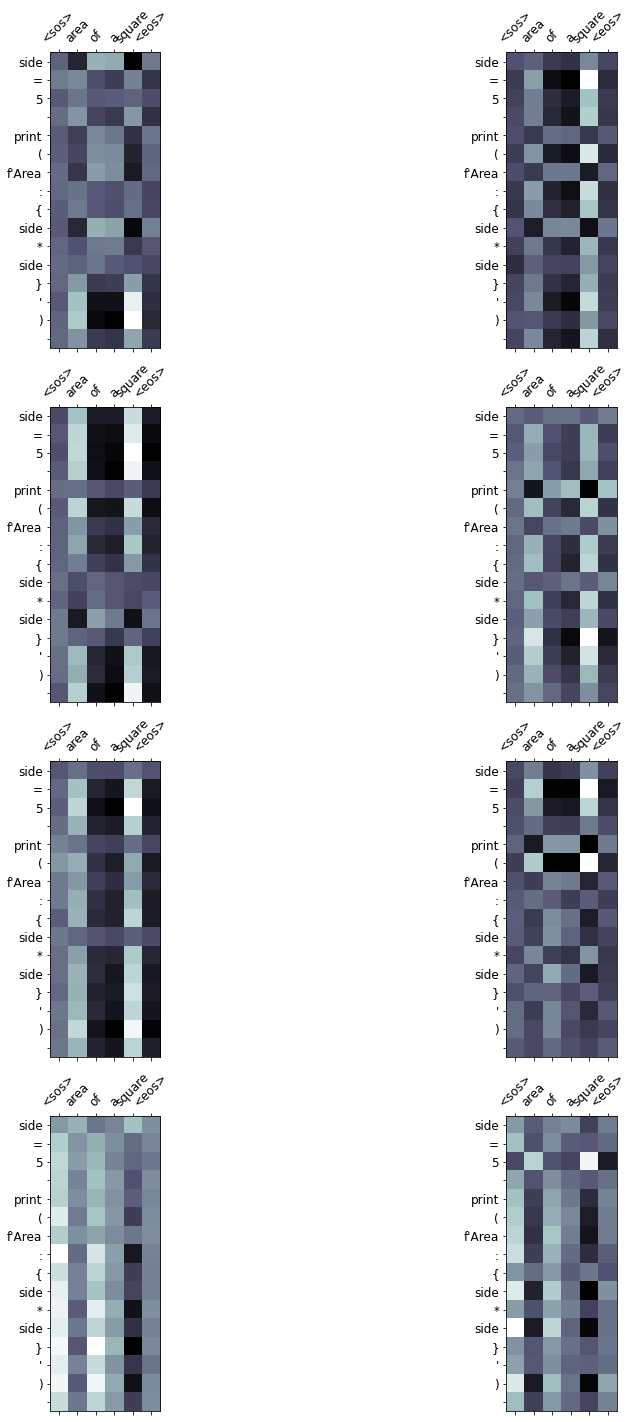

In [163]:
project_testing('area of a square')

Question:  add two numbers
Answer:
 num1 = 5465461 
 
 num2 = 8765468 
 
 sum = num1 + num2 
 
 print ( f'Sum : { sum } ' )


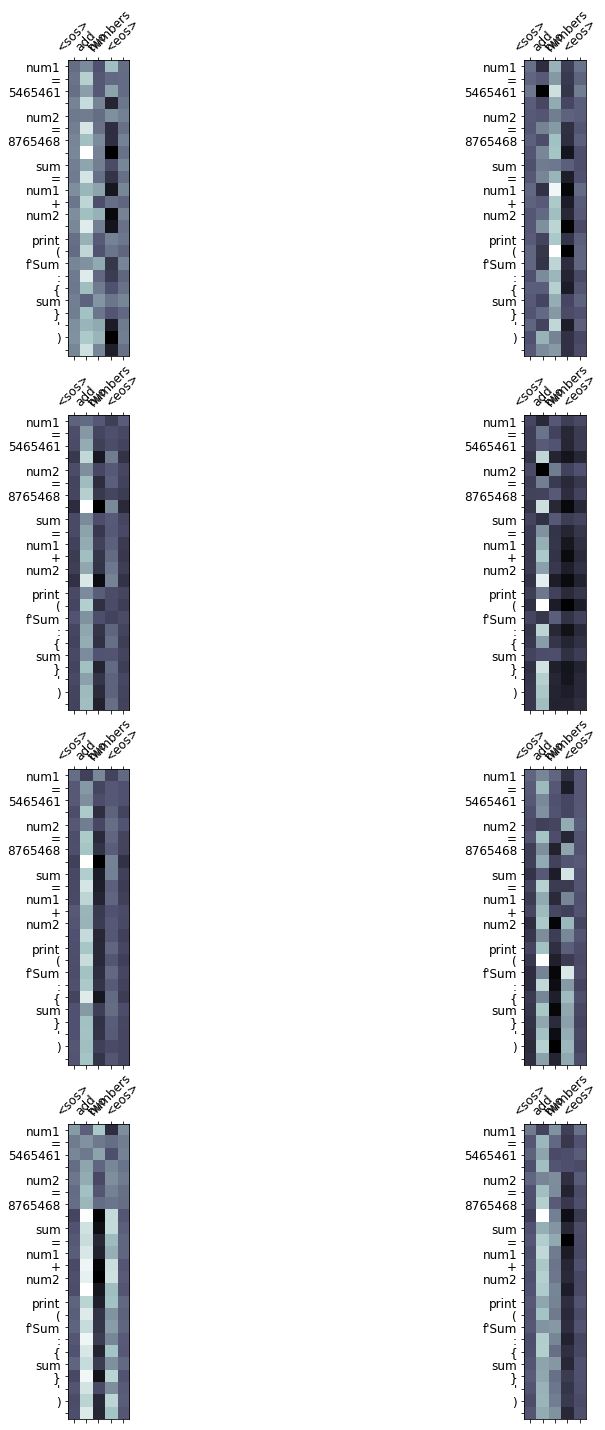

In [46]:
project_testing('add two numbers')

Question:  write a function to multiply two numbers
Answer:
 def multiply ( x , y ): 
 
     return x * y


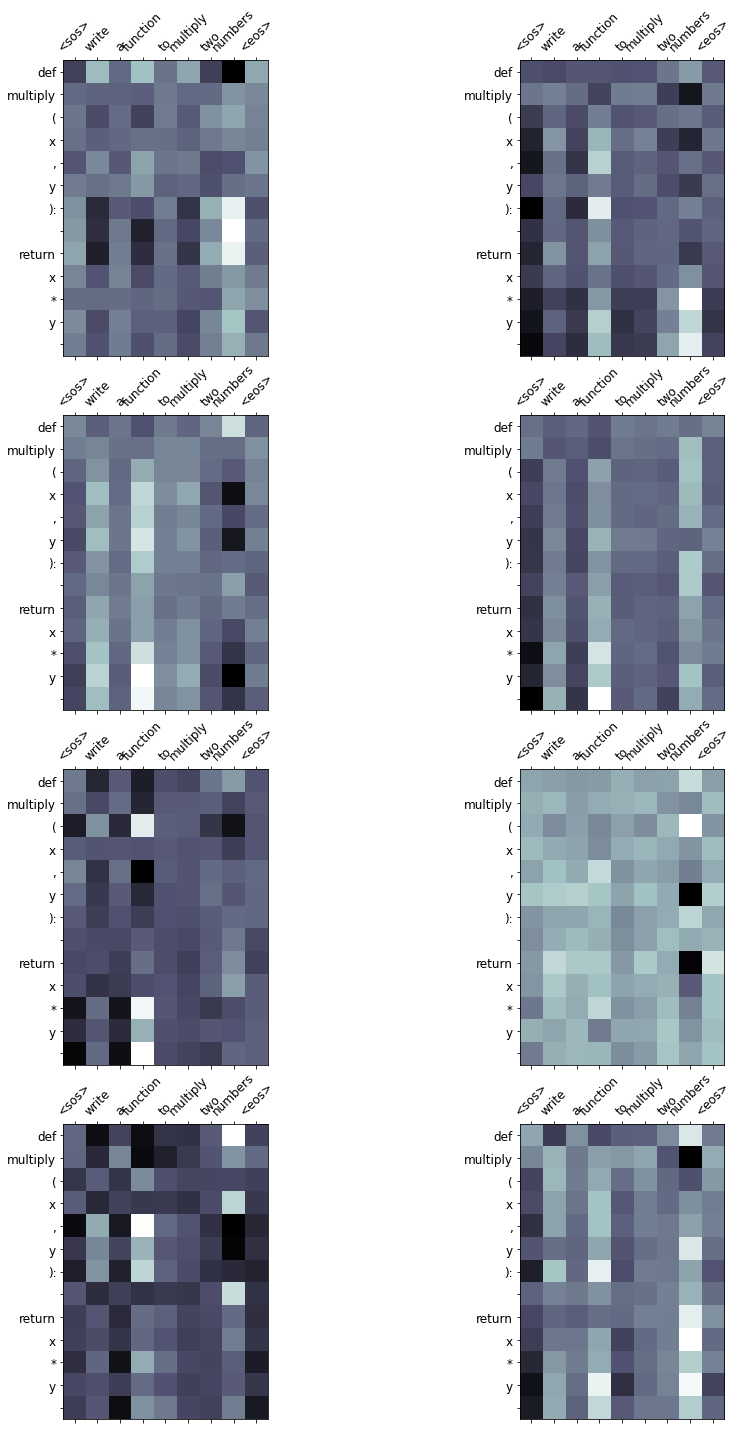

In [47]:
project_testing('write a function to multiply two numbers')

Question:  factorial
Answer:
 def factorial ( n ): 
 
     if n = = 1 : 
 
         return n 
 
     else : 
 
         return n * factorial ( n-1 )


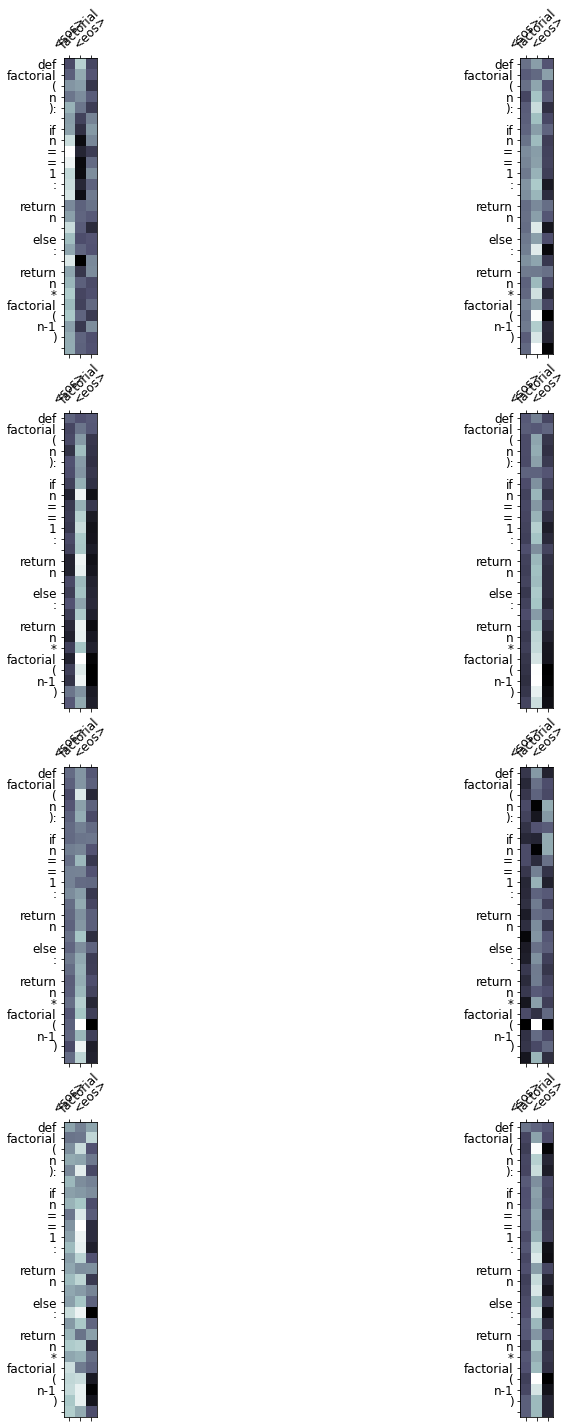

In [48]:
project_testing('factorial')

Question:  hcf
Answer:
      if x > y : 
 
         smaller = y 
 
     else : 
 
         smaller = x 
 
     for i in range ( 1 , smaller + 1 ): 
 
         if ( ( x % i = = 0 ) and ( y % i = = 0 ) ): 
 
             hcf = i 
 
     return hcf


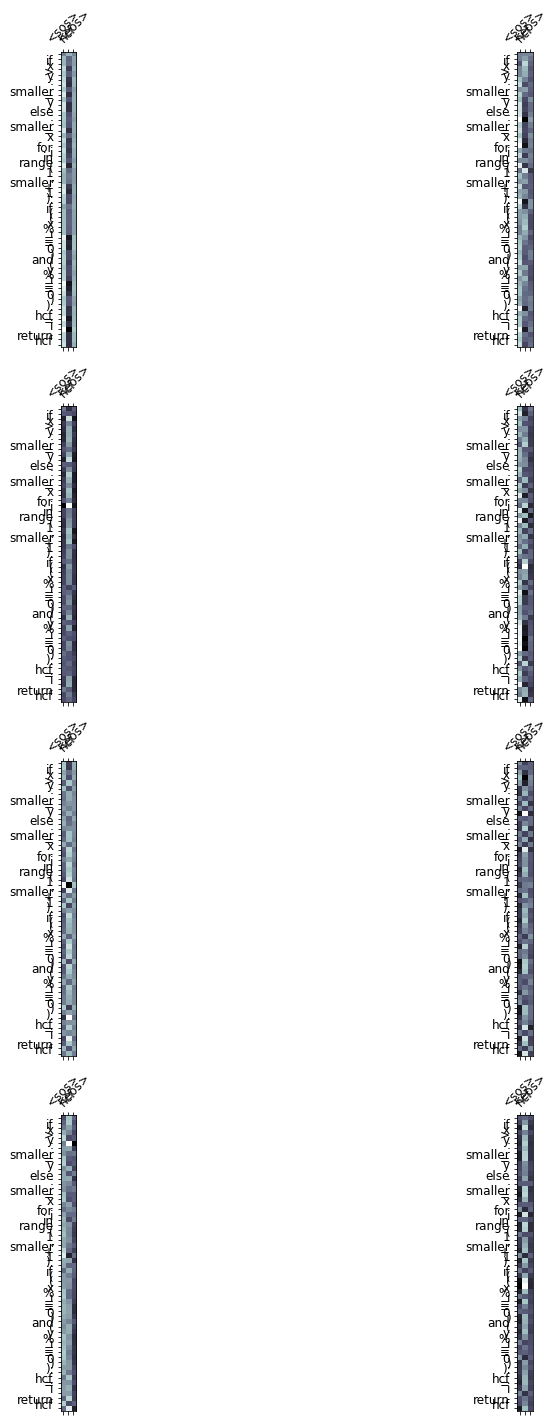

In [49]:
project_testing('hcf')

Question:  even numbers in a list
Answer:
 list1 = [ 10 , 21 , 4 , 45 , 66 , 93 , 11 ] 
 
 only_odd = [ x for x in list1 if x % 2 = = 0 ] 
 
 print ( " Odd numbers is " , list1 )


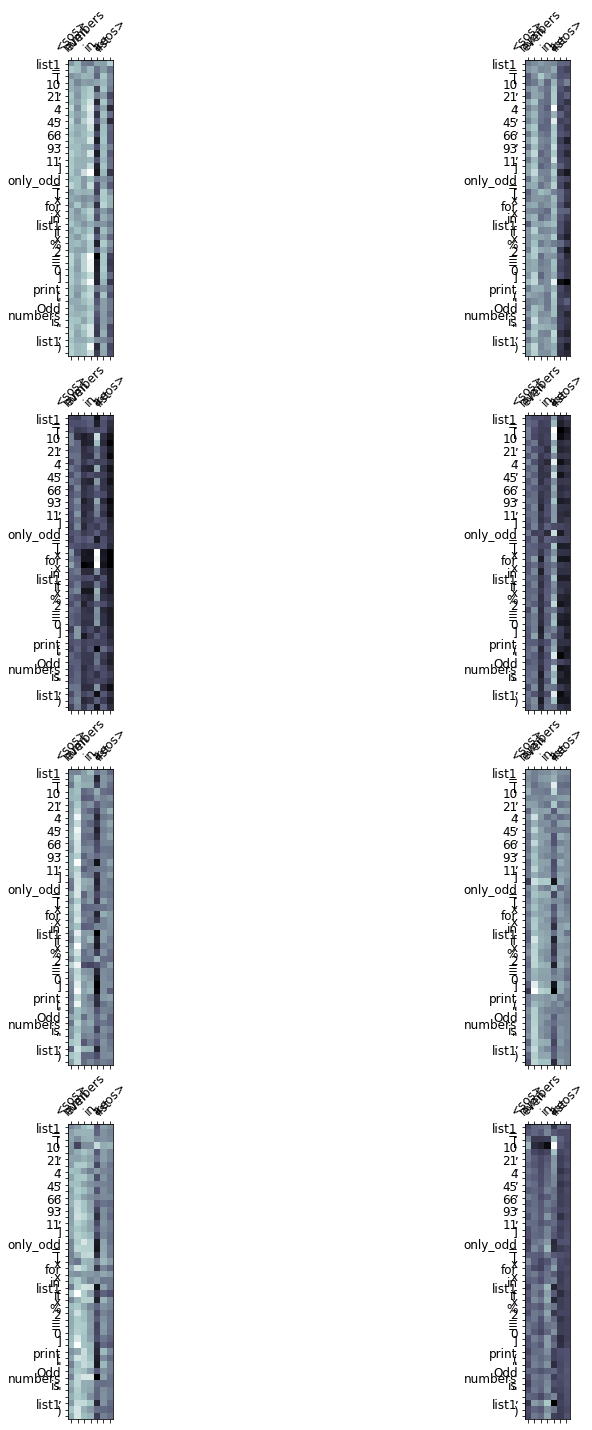

In [50]:
project_testing('even numbers in a list')

Question:  current date
Answer:
 from datetime import datetime 
 
 now = datetime.now ( ) 
 
 print ( now )


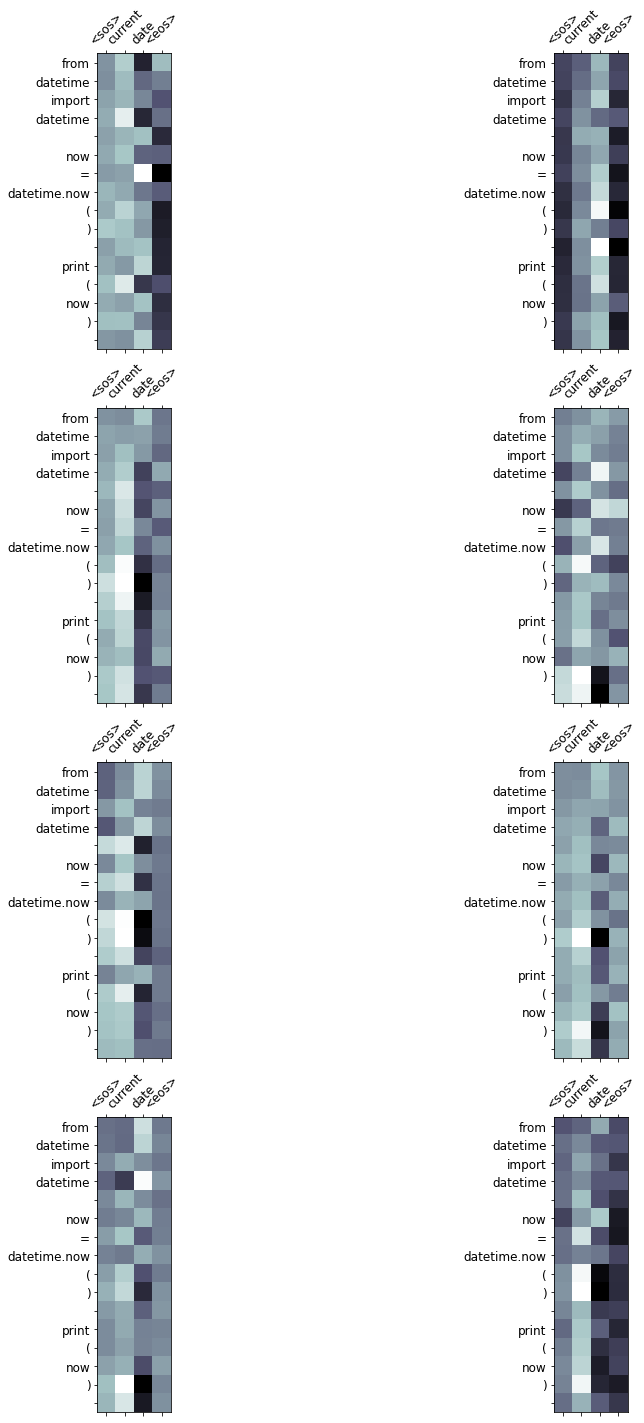

In [51]:
project_testing('current date')

Question:  write a program to reverse each word in a sentence
Answer:
 sentence = ' the quick brown fox ' 
 
 words = sentence.split ( ' ) 
 
 words.reverse ( ) 
 
 print ( ' ' ' .join ( words ) )


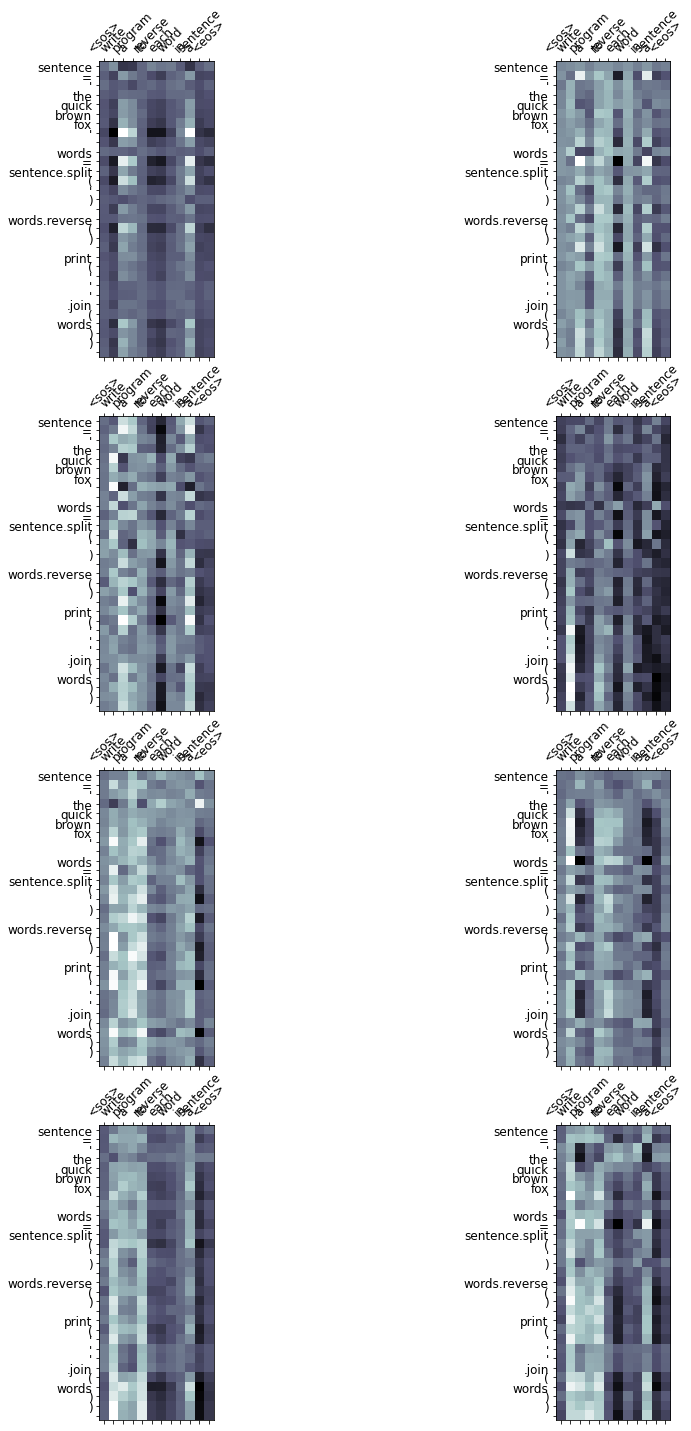

In [52]:
project_testing('write a program to reverse each word in a sentence')

Question:  convert binary to decimal
Answer:
 int ( ' 010101 ' , 2 )


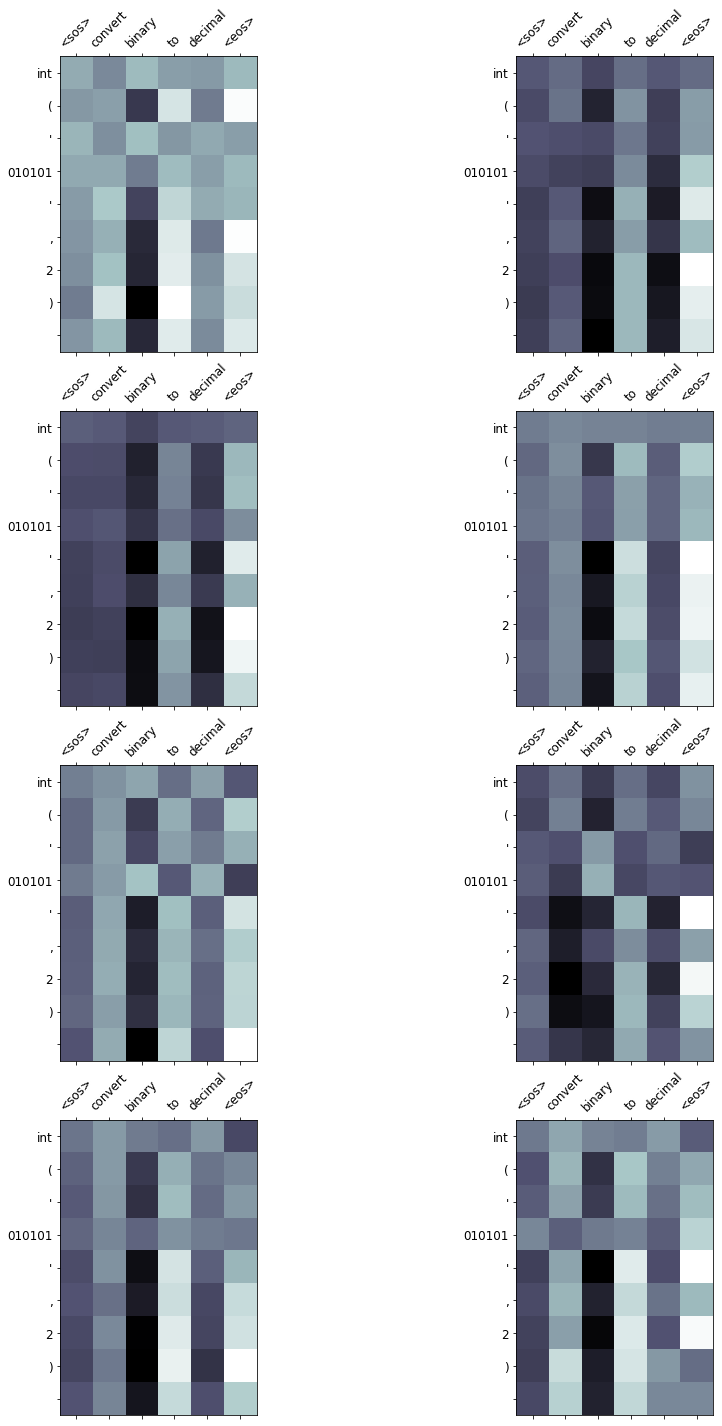

In [53]:
project_testing('convert binary to decimal')

Question:  convert input to date
Answer:
 from datetime import datetime 
 
 date_string = " Feb 25 2020   4:20PM " 
 
 datetime_object = datetime.strptime ( date_string , ' % b % d % Y % I : % M%p ' ) 
 
 print ( datetime_object )


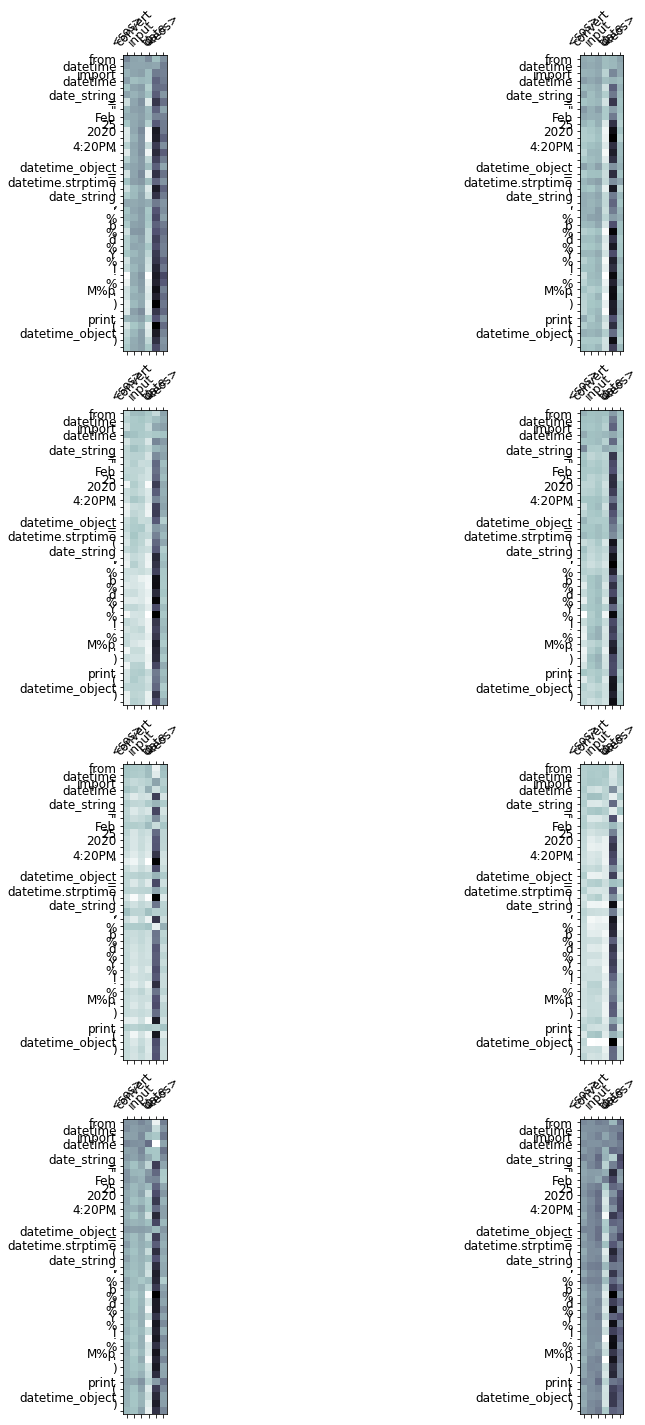

In [54]:
project_testing('convert input to date')

Question:  declare a 3x3 matrix
Answer:
 matrix = [ [ 1 , 2 , 3 ] , 
 
        [ 4 , 5 , 6 ] , 
 
        [ 7 , 8 , 9 ] ] ; 
 
 print ( [ i ] for i in range ( len ( matrix ) ) )


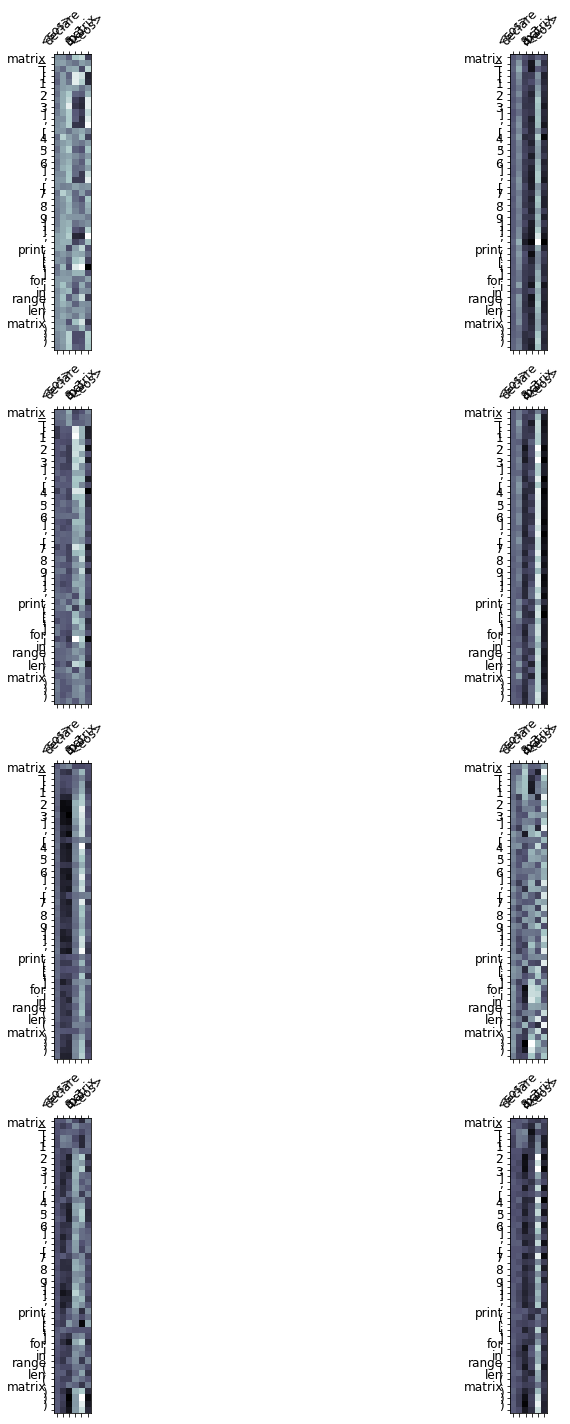

In [55]:
project_testing('declare a 3x3 matrix')

Question:  write a program to find the LCM
Answer:
 def compute_lcm ( x , y ): 
 
    if x > y : 
 
        greater = x 
 
    else : 
 
        greater = y 
 
    while ( True ): 
 
        if ( ( greater % x = = 0 ) and ( greater % y = = 0 ) ): 
 
            lcm = greater 
 
            break 
 
        greater + = 1 
 
    return lcm


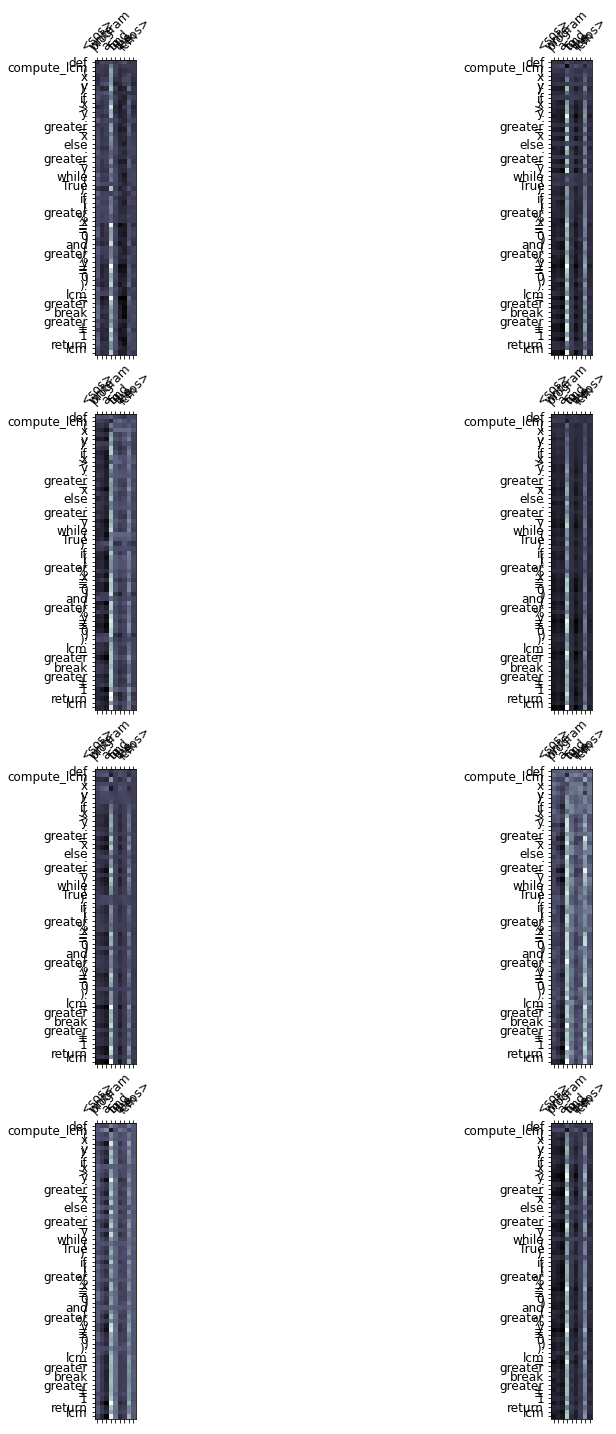

In [56]:
project_testing('write a program to find the LCM')

Question:  calculate interest
Answer:
 si = ( p * r * t ) / 100 
 
 print ( " The rate of interest is " , round ( 5 ) )


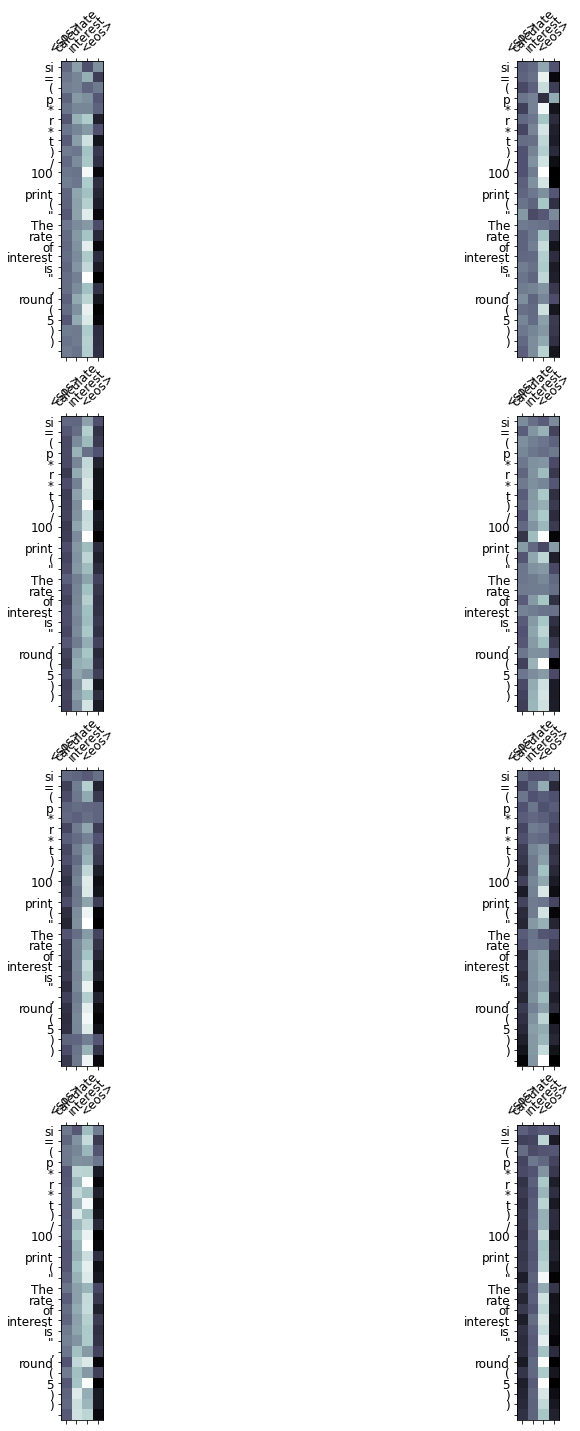

In [57]:
project_testing('calculate interest')

Question:  write a function to calculate the area of a triangle
Answer:
 def cal_rt_triangle_area ( base : float , height : float ) - > float : 
 
     if base and height : 
 
         return ( base * height ) / 2 
 
     else : 
 
         return None


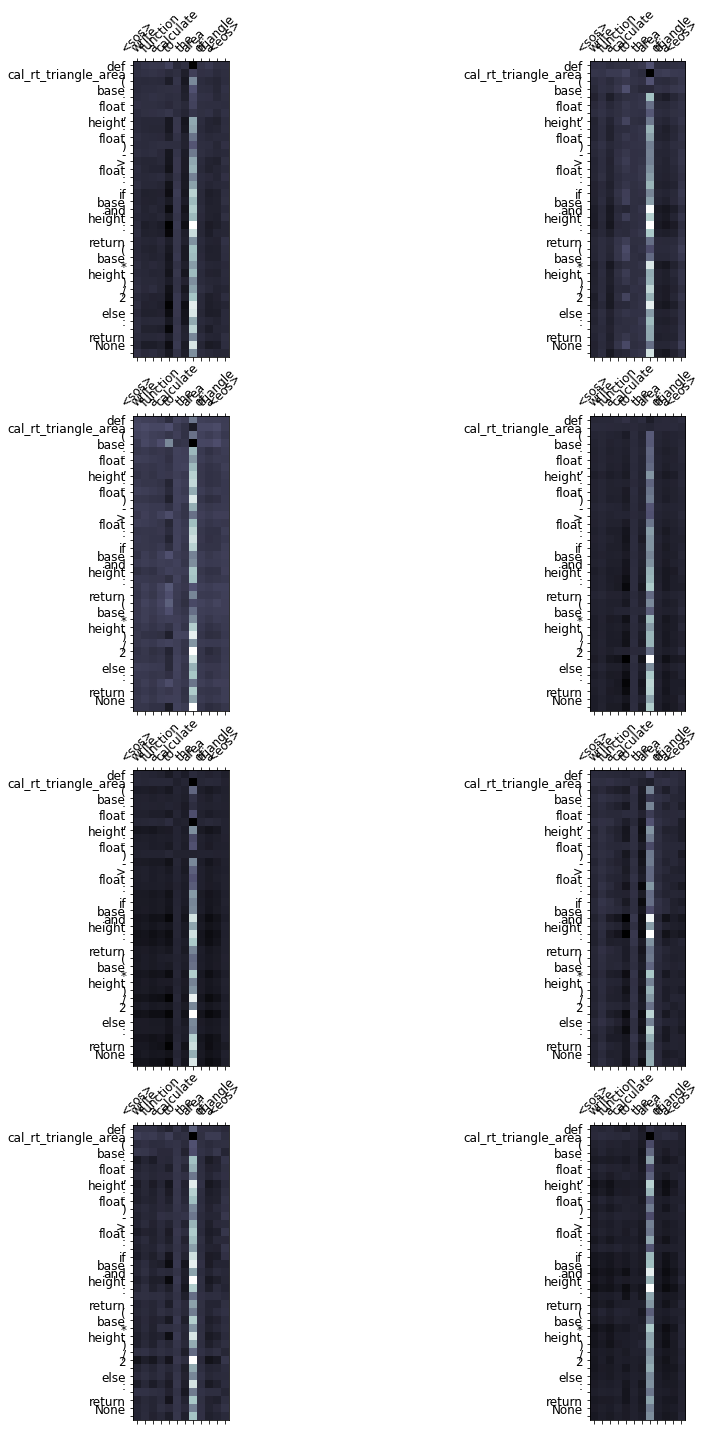

In [66]:
project_testing('write a function to calculate the area of a triangle')

Question:  write a function to check if a string is palindrome
Answer:
 def isPalindrome ( s ): 
 
     return s = = s [ : : -1 ]


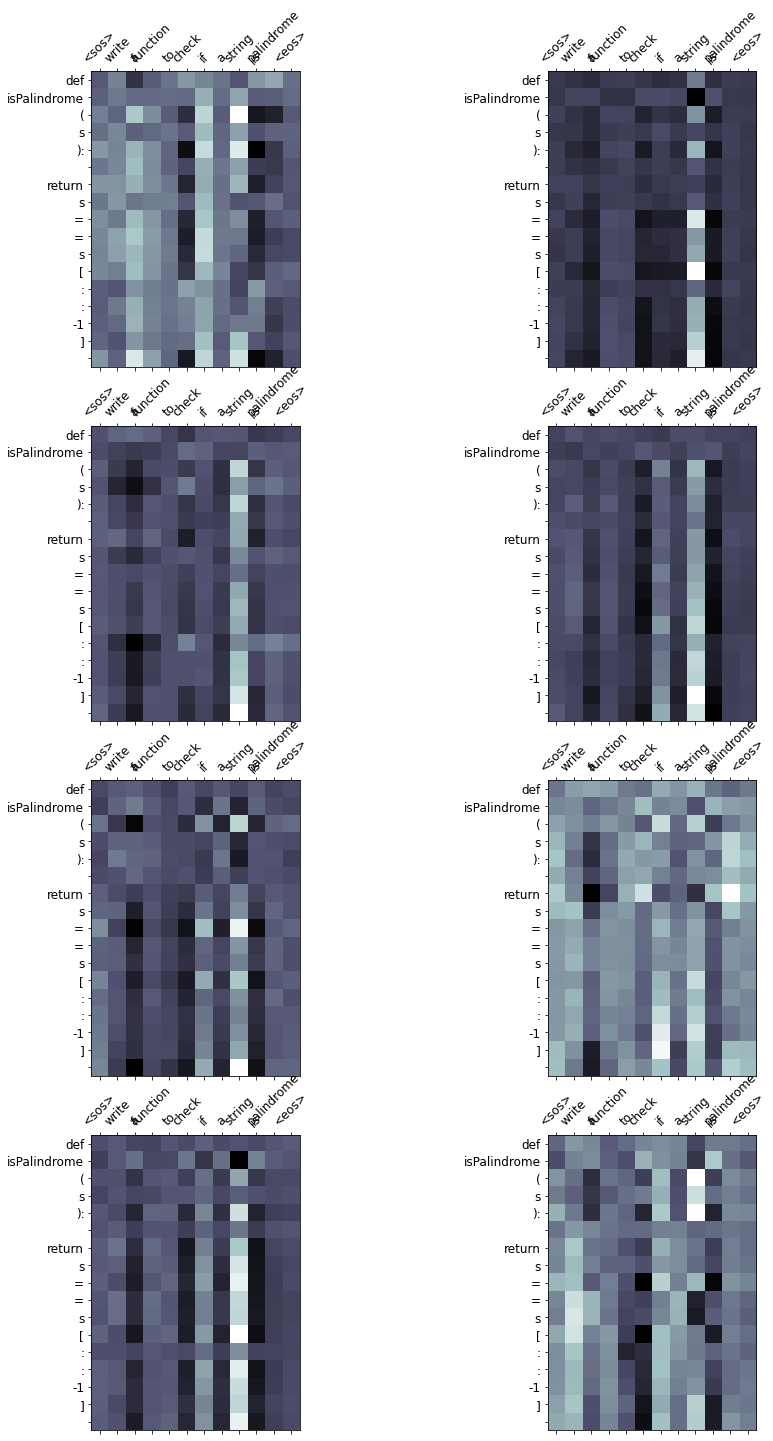

In [67]:
project_testing('write a function to check if a string is palindrome')

Question:  write a program to check if a number is positive or negative
Answer:
 num = int ( input ( " Enter a number : ") ) 
 
 if num > 0 : 
 
    print ( " Positive number " ) 
 
 elif num = = 0 : 
 
    print ( " Zero " ) 
 
 else : 
 
    print ( " Negative number " )


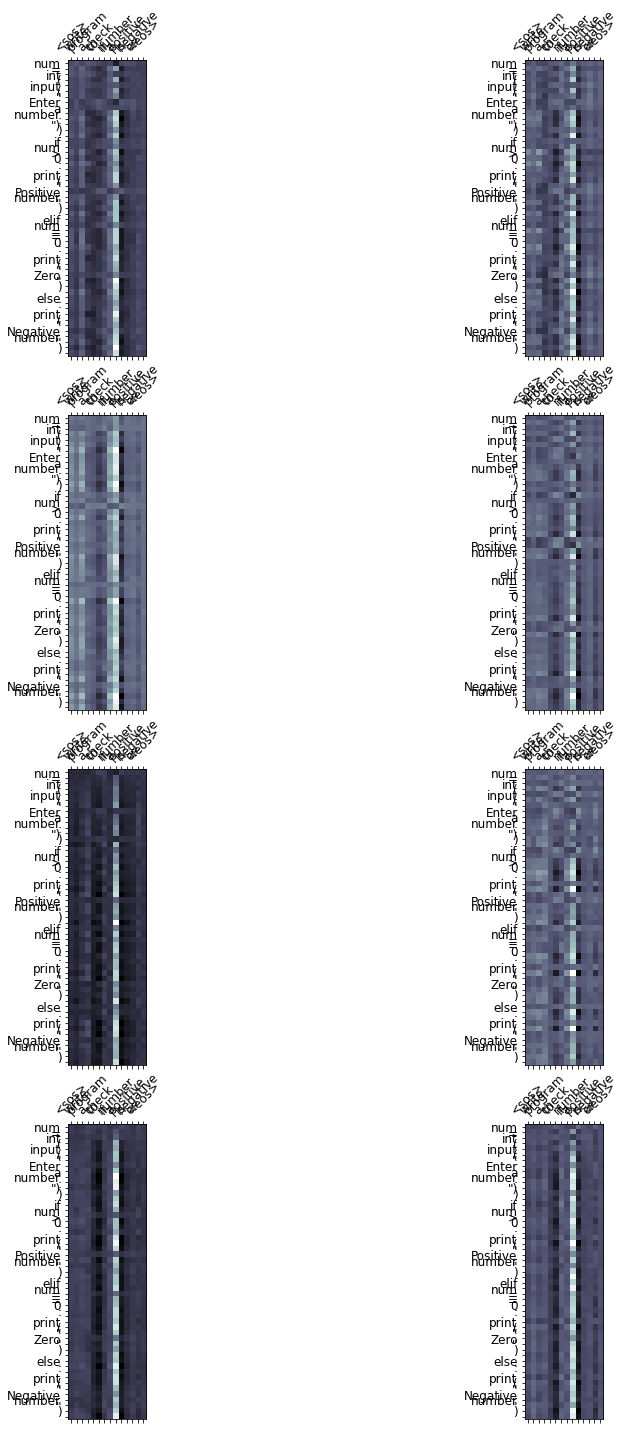

In [70]:
project_testing('write a program to check if a number is positive or negative')

Question:  reverse sort a list
Answer:
 my_list = [ 4 , 3 , 2 , 9 , 10 , 44 , 1 ] 
 
 my_list.sort ( reverse = True ) 
 
 print ( f"Descending Order list : , { my_list } ")


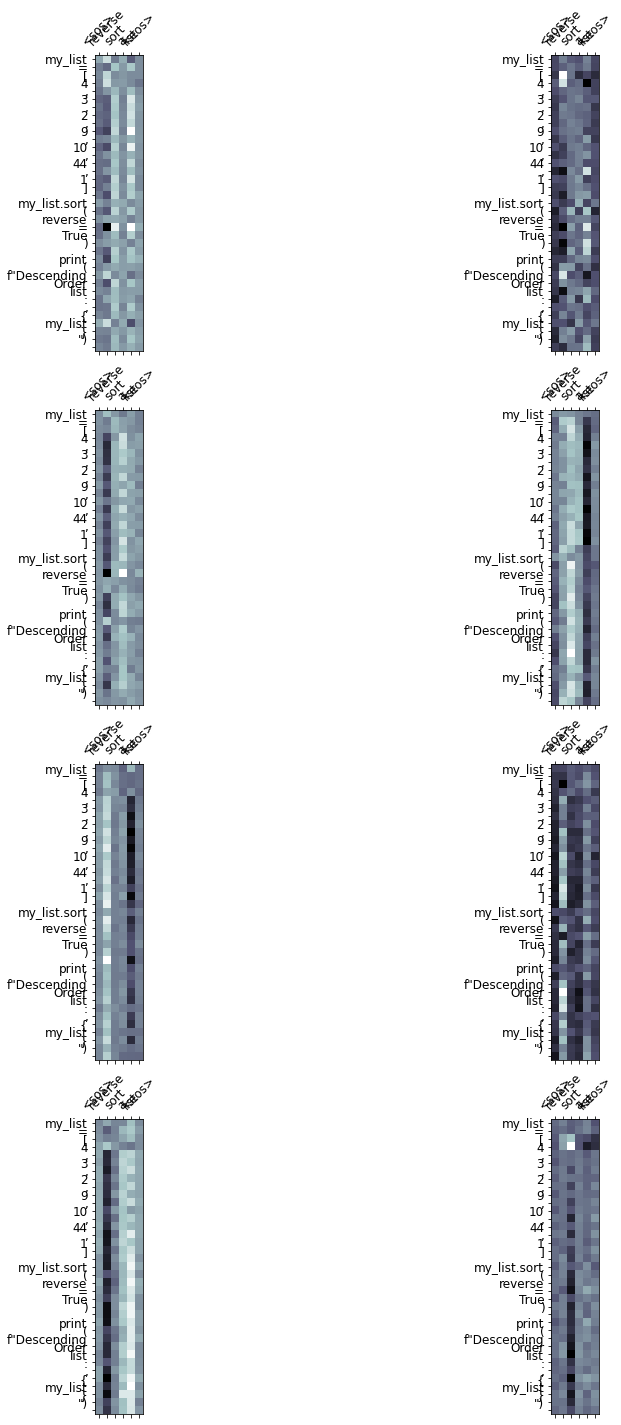

In [87]:
project_testing('reverse sort a list')

Question:  write a function to invert a dictionary
Answer:
 def invert_dict ( input_dict ): 
 
   my_inverted_dict = { value : key for key , value in input_dict.items ( ) } 
 
   return my_inverted_dict


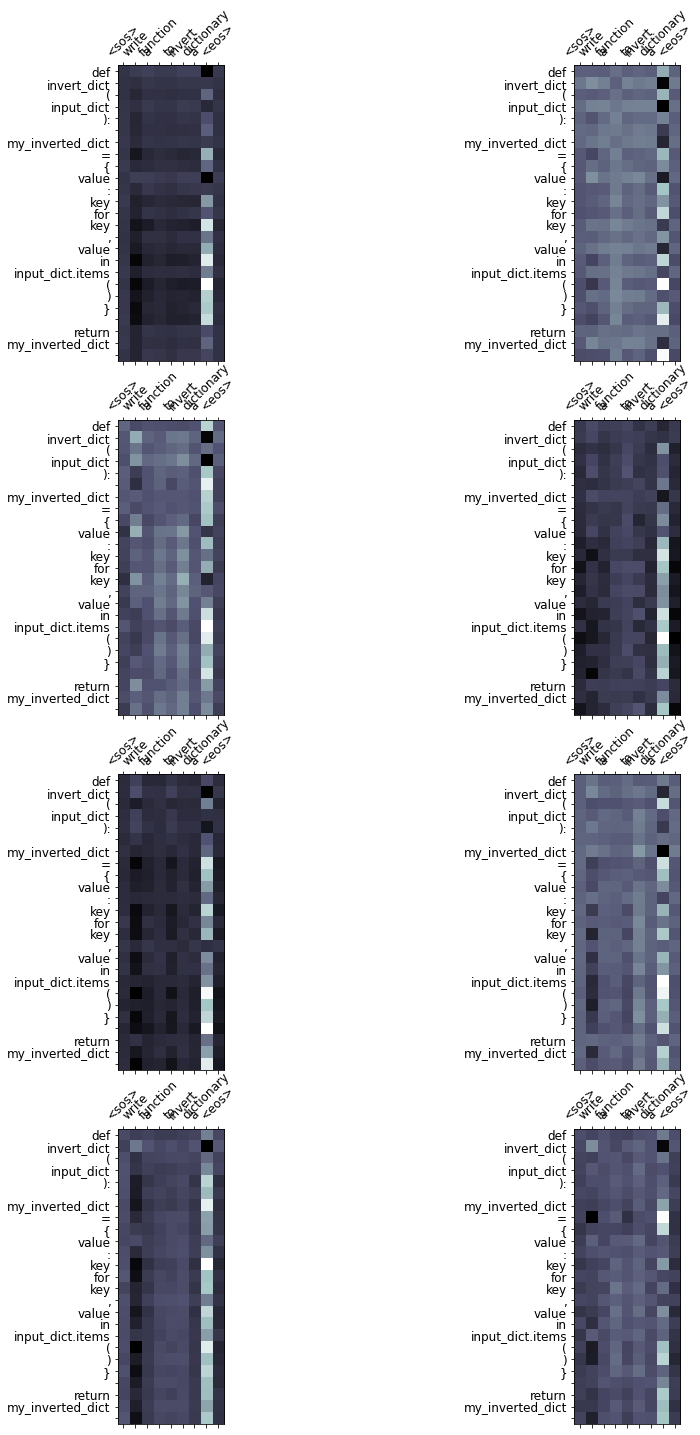

In [80]:
project_testing('write a function to invert a dictionary')

Question:  write a function to find the square of a number
Answer:
 def cube ( num ): 
 
     return num * * 2


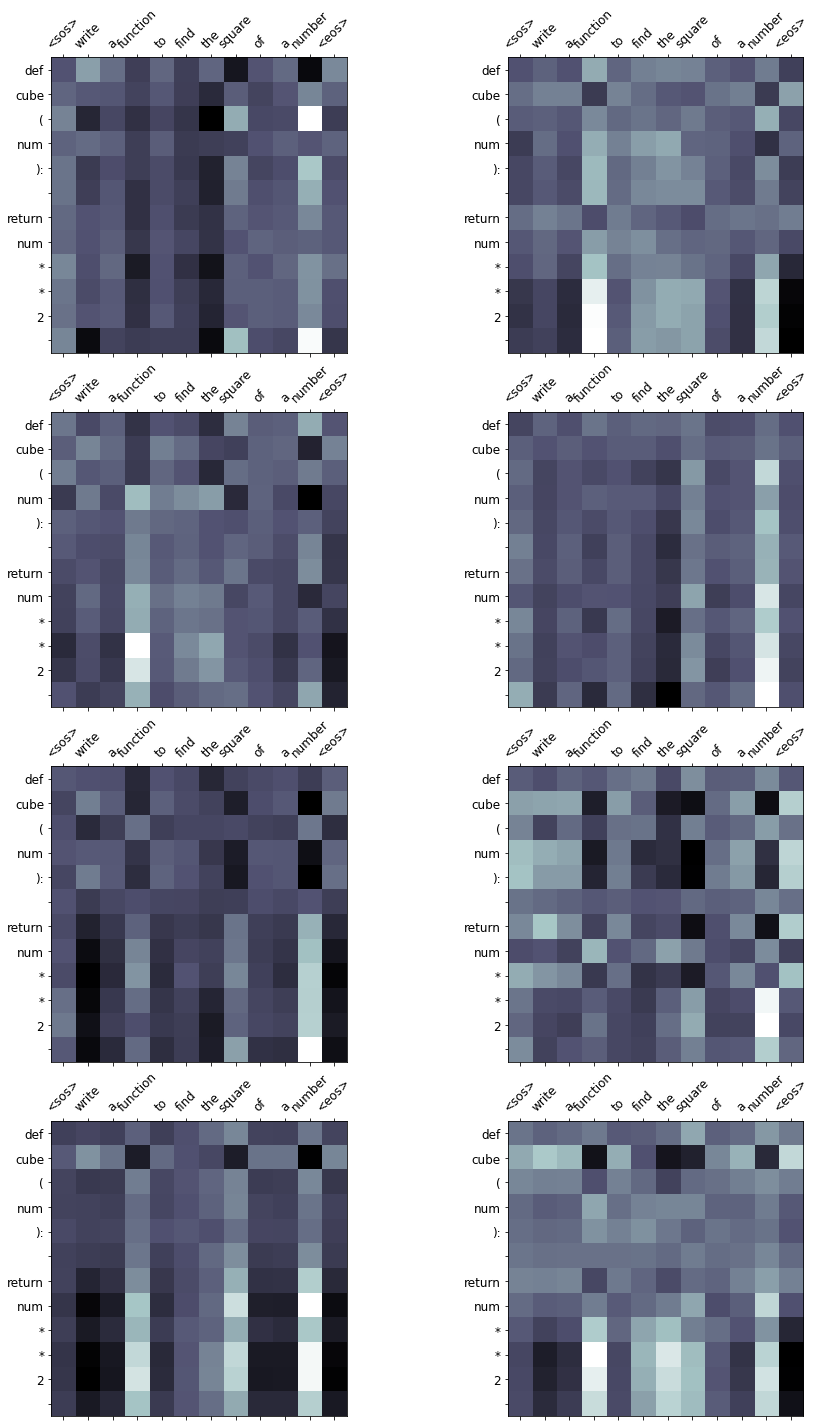

In [106]:
project_testing('write a function to find the square of a number')

Question:  write a function to print factors of a number
Answer:
 def print_factors ( x ): 
 
    print ( " The factors of " , x , " are : ") 
 
    for i in range ( 1 , x + 1 ): 
 
        if x % i = = 0 : 
 
            print ( i )


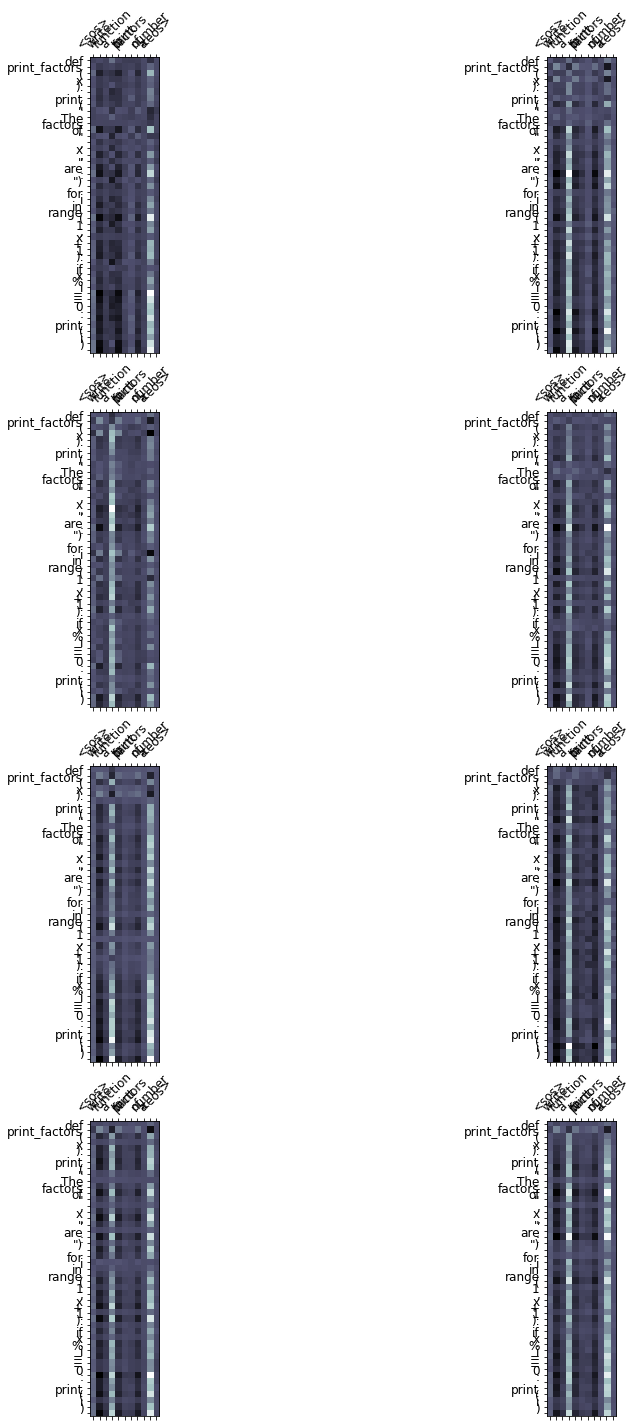

In [124]:
project_testing('write a function to print factors of a number')

Question:  write a function to calculate the area of a circle
Answer:
 def cal_area_circle ( r ): 
 
     pi = 3.14 
 
     return pi * r * * 2


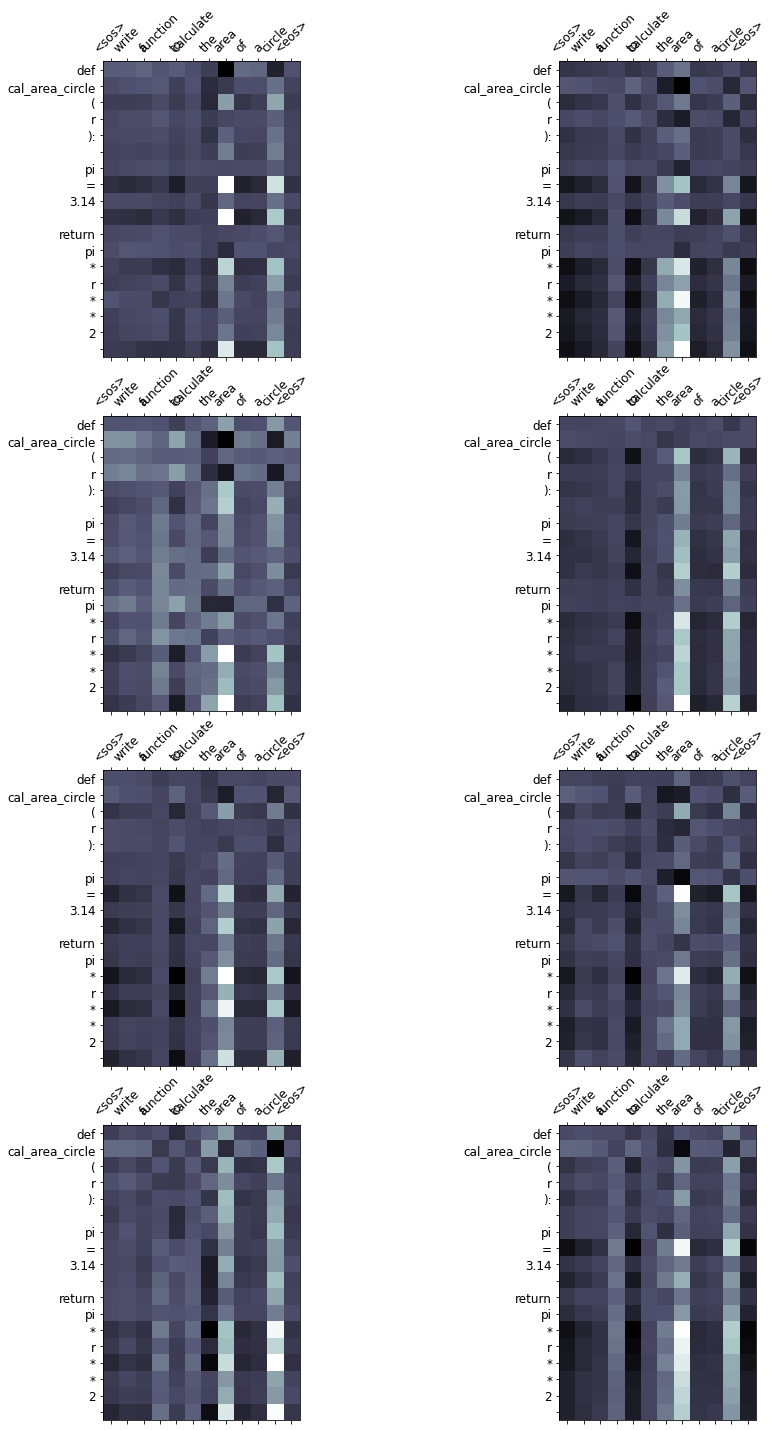

In [136]:
project_testing('write a function to calculate the area of a circle')

Question:  write a function to check if a list has duplicate
Answer:
 def all_equal ( lst ): 
 
   return len ( set ( lst ) ) = = len ( lst )


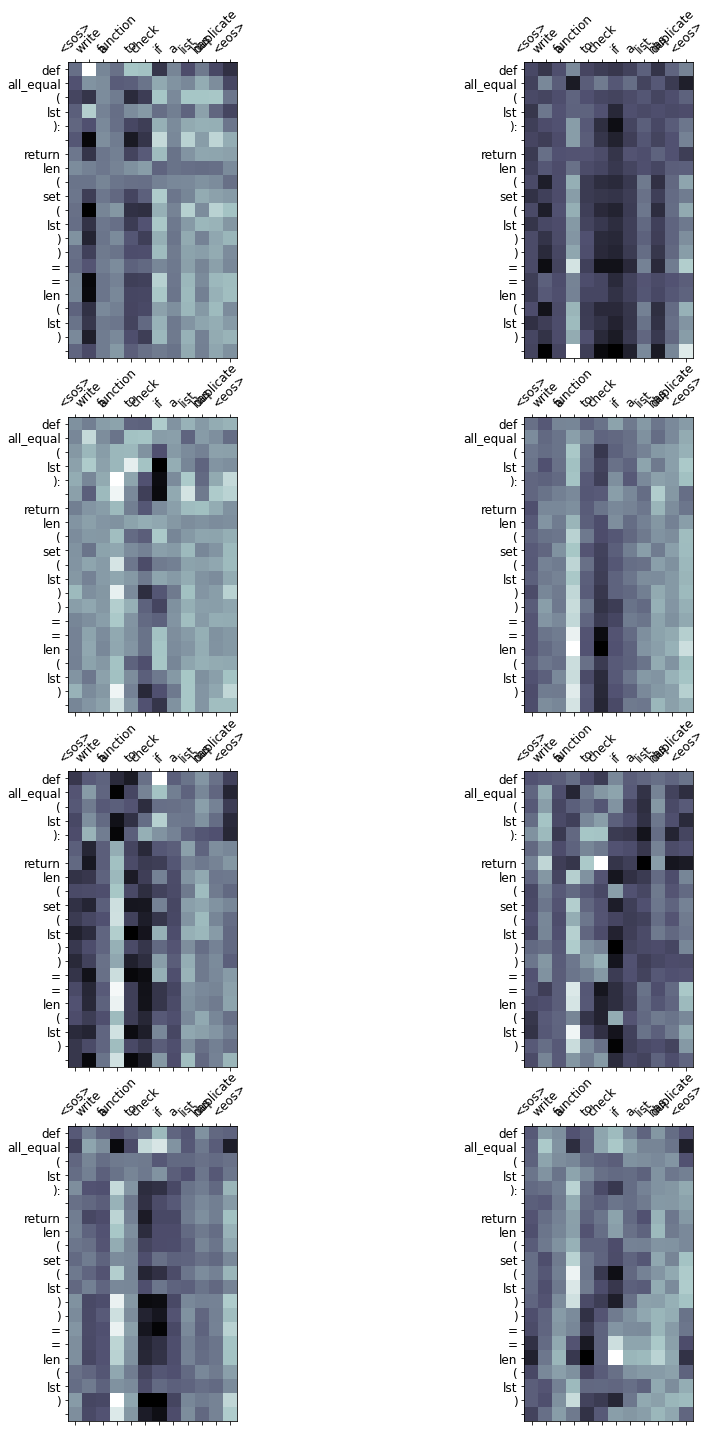

In [159]:
project_testing('write a function to check if a list has duplicate')

Question:  write a program to find abs of a number
Answer:
 import math 
 
 number = 34.564 
 
 fa = math.fabs ( number ) 
 
 print ( ' Fabs ' , fa )


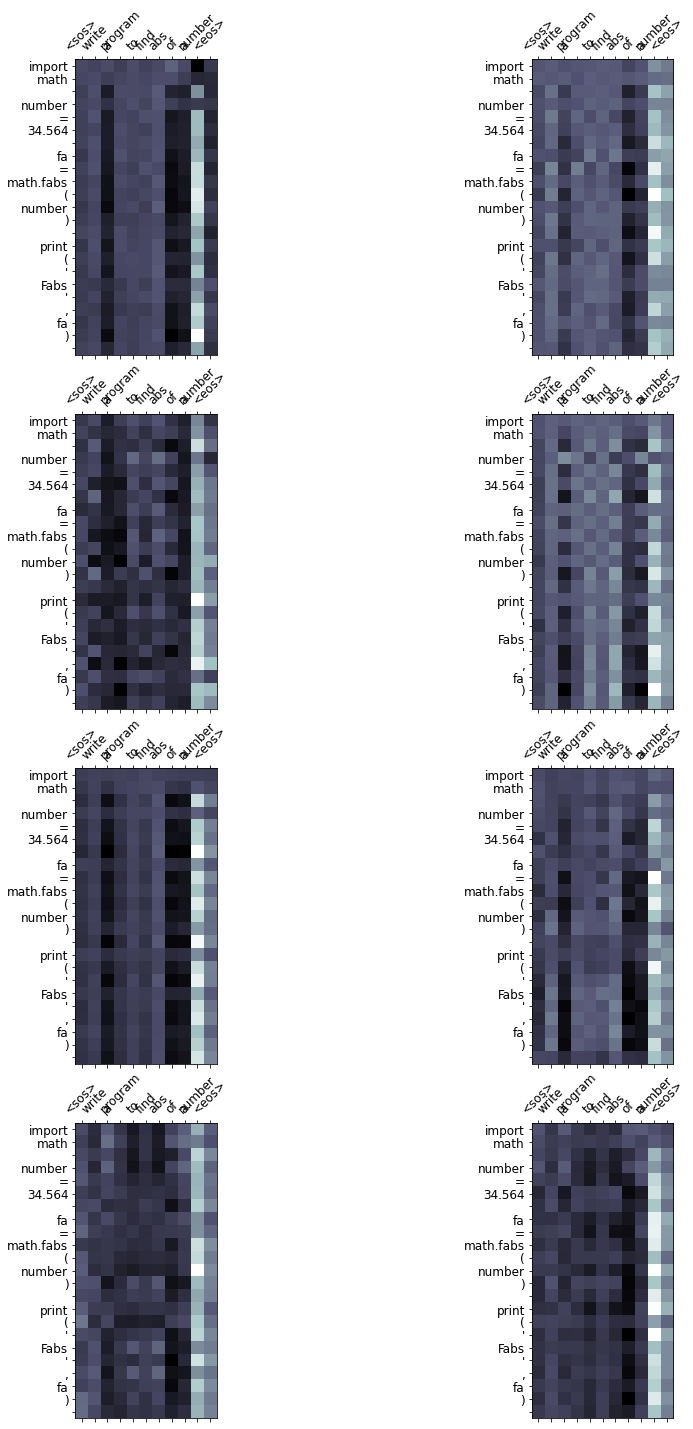

In [191]:
project_testing('write a program to find abs of a number')

Question:  write a function to convert list to tuple
Answer:
 def convert_list_to_tuple ( list_input ): 
 
     return tuple ( list_input )


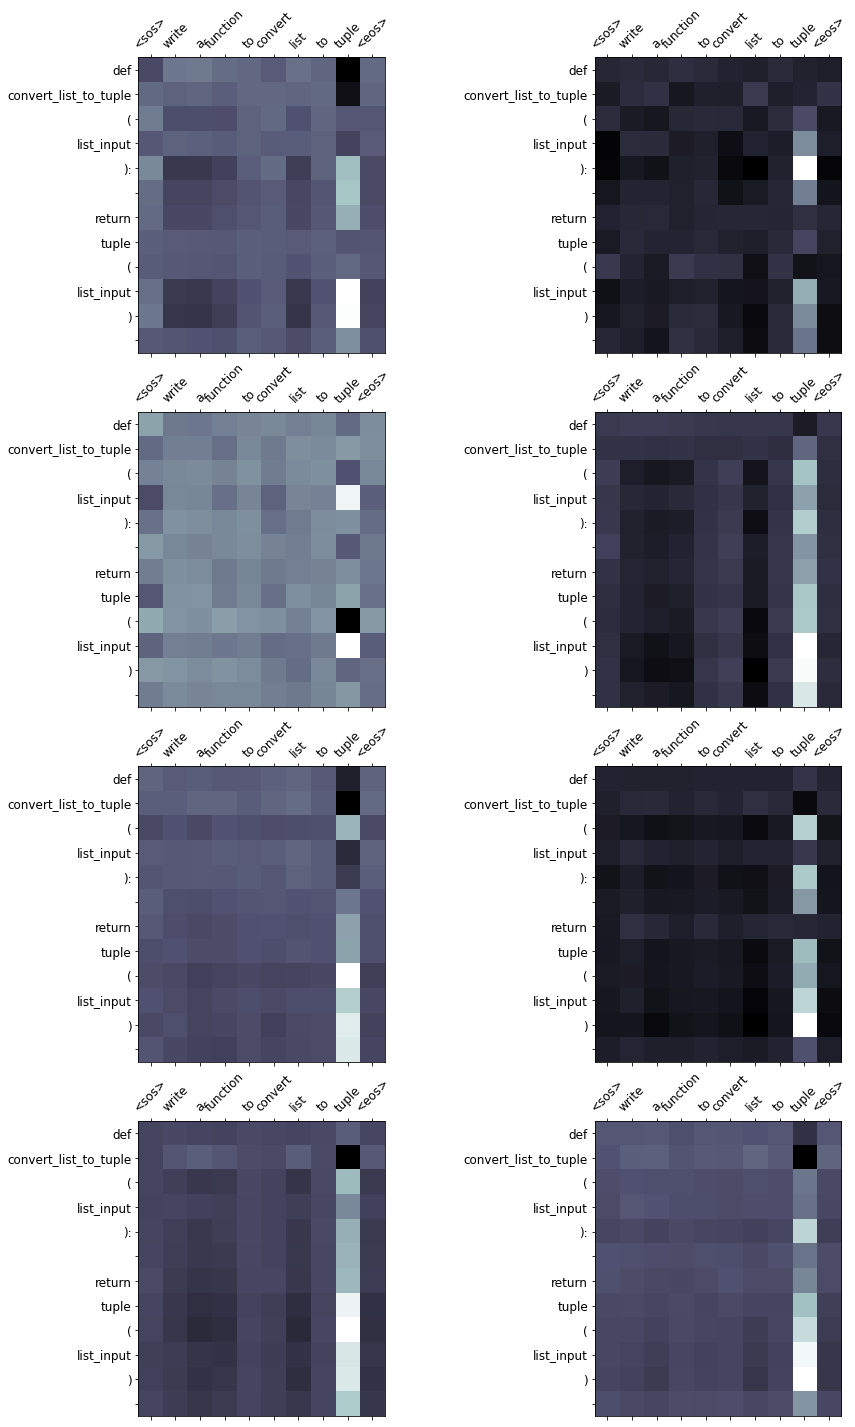

In [220]:
project_testing('write a function to convert list to tuple')

Question:  write a function to sum of n numbers
Answer:
 def sum_of_nums ( n ): 
 
    if n < = 1 : 
 
       return n 
 
    else : 
 
       return n + sum_of_nums ( n-1 )


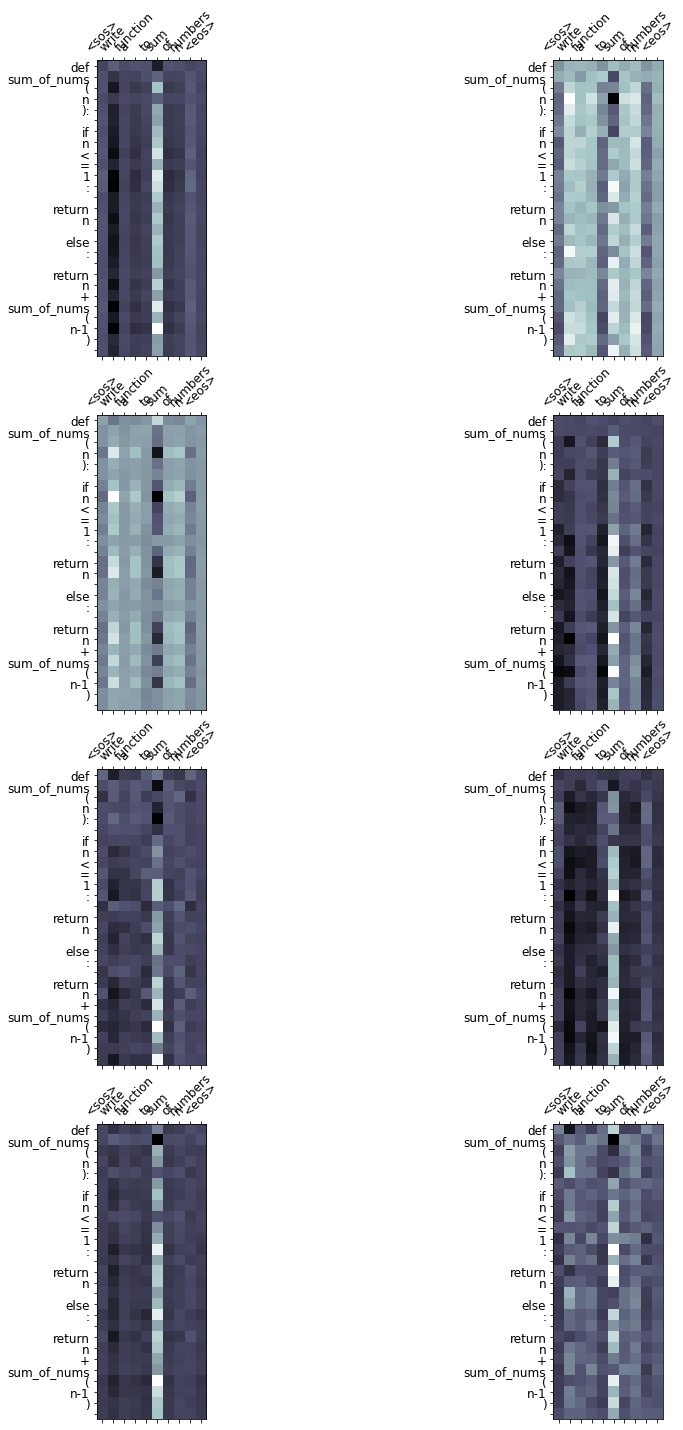

In [235]:
project_testing('write a function to sum of n numbers')